# Setup

#### Load Packages

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

# add parent directory to path
import sys
sys.path.append('..')

# import packages
import numpy as np
import matplotlib.pyplot as plt
import time

# import modules
import LimitedCommitmentModel as lmc
from figures import *
from checks import *

#### Compile C++ files

In [2]:
# compile c++ files
model = lmc.HouseholdModelClass(par={'do_cpp':True,'num_Ctot':100})
try:
    model.link_to_cpp(force_compile=True)
except:
    model.cpp.delink()
    model.link_to_cpp(force_compile=True)

In [3]:
type(model)

LimitedCommitmentModel.HouseholdModelClass

In [4]:
for i in model.sol.Vm_single_to_couple.shape:
    print(i)

10
21
41
50


## User Settings

#### Specify Models

In [5]:
# Default settings
do_simulate = True
do_load     = False
do_save     = False

baseline_settings = {
    # Number of periods
    'T': 10,
    
    # Technical settings
    'threads': 50,
    'do_cpp': True,
    'do_egm': True,
    
    # Numerical settings
    
    # Parameters
    
}

# Model settings
specs = {
    # 'VFI':    
    #     {'latexname':'Model 1', 
    #      'load': do_load,
    #      'save': do_save,
    #      'par':{**baseline_settings,
    #             'do_egm': False,
    #             'p_meet': 0.0,
    #             }
    #     },
    # 'EGM':    
    #     {'latexname':'Model 1', 
    #      'load': do_load,
    #      'save': do_save,
    #      'par':{**baseline_settings,
    #             'p_meet': 0.0,
    #             }
    #     },
        
    # 'Model 1':    
    #     {'latexname':'Model 1', 
    #      'load': do_load,
    #      'save': do_save,
    #      'par':{**baseline_settings,
    #             }
    #     },
        
    'Model 2':    
        {'latexname':'Model 1', 
         'load': do_load,
         'save': do_save,
         'par':{**baseline_settings,
                'div_A_share': 0.1,
                }
        },
        
    # 'Model 3':    
    #     {'latexname':'Model 1', 
    #      'load': do_load,
    #      'save': do_save,
    #      'par':{**baseline_settings,
    #             'p_meet': 0.0,
    #             }
    #     },
}

## Run models

#### Overview

In [6]:
# Make table
print_specs_table(specs)

           |  Model 2  |
------------------------
T          |     10    |
do_egm     |    True   |
div_A_share|    0.1    |
threads    |     50    |
do_cpp     |    True   |


#### Solve/Load models

In [7]:
# solve different models
models = {}
for name,spec in specs.items():
        #unpack
        par = spec['par']
        do_load = spec['load']
        do_save = spec['save']
        
        if do_load:
            print(f'loading {name}...')
        else:
            print(f'running {name}...')
        
        # setup model
        models[name] = lmc.HouseholdModelClass(name=name, par=spec['par'], load=do_load)
        models[name].spec = spec
        
        # link to cpp
        try:
            models[name].link_to_cpp(force_compile=False)
        except:
            models[name].cpp.delink()
            models[name].link_to_cpp(force_compile=False)
        
        # solve and simulate
        if not do_load:
            # solve
            time0 = time.time()
            models[name].solve()
            solution_time = time.time()-time0
            models[name].sol.solution_time[0] = solution_time
            
            #simulate
            if do_simulate:
                models[name].simulate()
                print('here')
        
        # save model
        if do_save:
            models[name].save()
        
# Save model names
model_names  = list(models.keys())

running Model 2...


here


#### Speed

In [8]:
for name in model_names:
    solution_time = models[name].sol.solution_time
    minutes, seconds = divmod(solution_time, 60)
    seconds, ms      = divmod(seconds*100, 100)
    print(f"{name:16}: {int(minutes):2} minutes, {int(seconds):2} seconds, {int(ms):2} ms")


Model 2         :  0 minutes,  0 seconds, 24 ms


In [9]:
def getVariablesWith(*args: str, no: list = None, model = model):
    return [var for var in list(model.sol.__dict__.keys()) if all(words in var for words in args) and (no is None or all(words not in var for words in no))]

Cw_priv = getVariablesWith('Cw_priv_')
Cm_priv = getVariablesWith('Cm_priv_')
Cw_single = getVariablesWith('Cw', 'to_single', no=['tot'])
Cm_single = getVariablesWith('Cw', 'to_single', no=['tot'])
C_couple = getVariablesWith('C', 'to_couple', no=['tot'])
EmargV = getVariablesWith('EmargV')
Vw = getVariablesWith('Vw', no=['marg','vec'])
Vm = getVariablesWith('Vm', no=['marg','vec'])

# Figures

In [17]:
# Choose index
t  = 0
iP = 10
iL = 20
iA = 30
idx2 = (t,iP,iL,iA)

# alternative index
idx1 = (t,iP-8,iL,iA)
idx3 = (t,iP+8,iL,iA)
indexes = {'low power':idx1,
       'even power': idx2, 
       'high power': idx3}

print(f"Power : {models[model_names[0]].par.grid_power[iP]}")
print(f"Love  : {models[model_names[0]].par.grid_love[iL]}")
print(f"Assets: {models[model_names[0]].par.grid_A[iA]}")

Power : 0.5
Love  : 0.0
Assets: 7.31591472429611


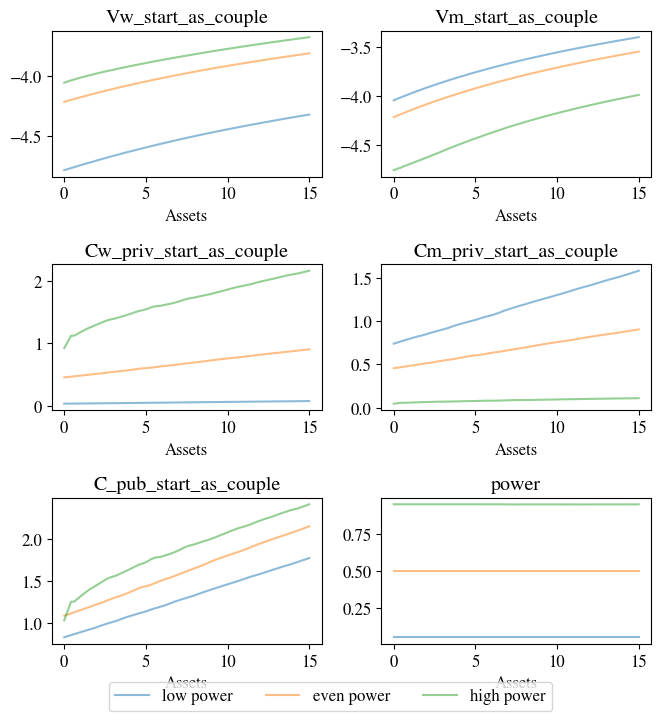

In [19]:
indexes = indexes
# indexes = idx2
variables = ['Vw_start_as_couple', 'Vm_start_as_couple', 'Cw_priv_start_as_couple', 'Cm_priv_start_as_couple', 'C_pub_start_as_couple', 'power']

plotter = ModelPlot('variables', models, variables, indexes)

# plotter.plot_using(plot_var_over_x, shared_legend=True, subplot_settings={'x':'assets'})
plotter.plot_using(plot_var_over_assets, shared_legend=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

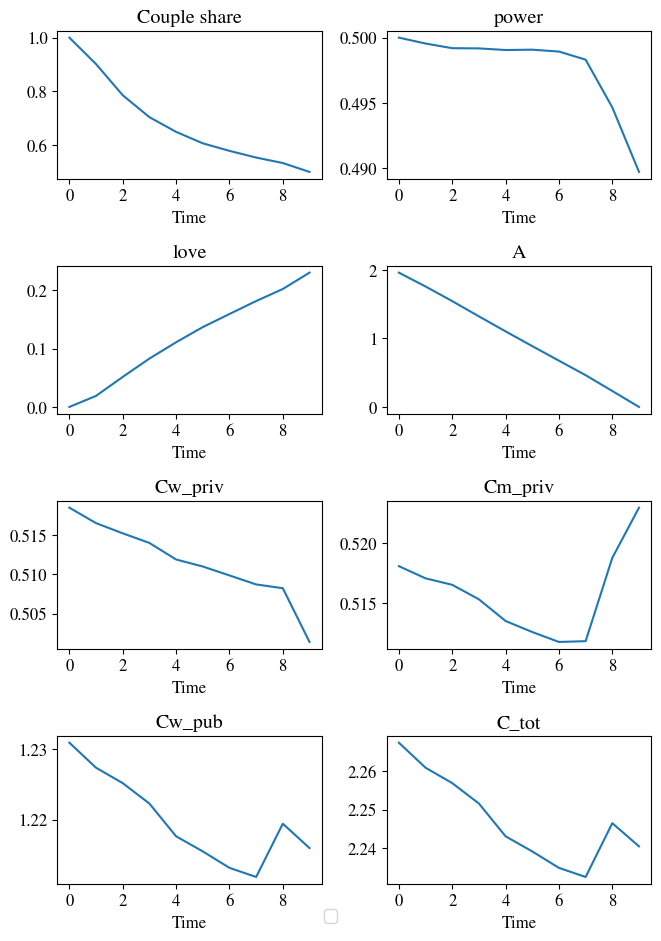

In [31]:
mask = models[model_names[0]].sim.couple==1
indexes = {'mean': lambda x: np.mean(x, axis=0, where=mask),
}
variables = ['couple', 'power', 'love', 'A', 'Cw_priv', 'Cm_priv', 'Cw_pub', 'C_tot']

plotter = ModelPlot('variables', models, variables, indexes)

# plotter.plot_using(plot_var_over_x, shared_legend=True, subplot_settings={'x':'assets'})
fig = plotter.plot_using(plot_simulated, shared_legend=True)

# get axes
ax = fig.get_axes()
# remove all curves in axes[0]
ax[0].clear()
ax[0] = plot_simulated(models[model_names[0]], 'couple', lambda x: np.mean(x, axis=0), ax=ax[0], title='Couple share')
ax[0].legend().remove()

fig

## Bargaining

In [13]:
model_plot(models, plot_surplus, [''], idx1, shared_legend=True, subtitles=model_names)

NameError: name 'model_plot' is not defined

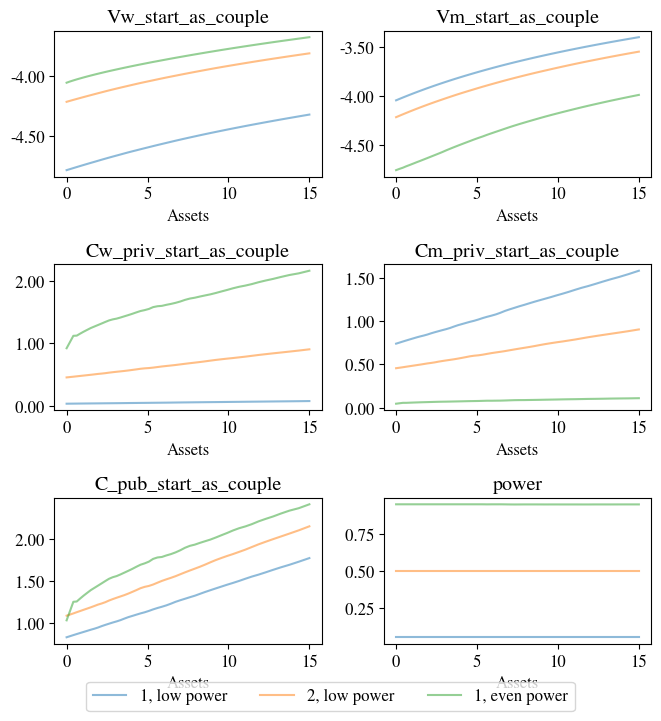

In [ ]:
var = ['Vw_couple_to_couple']
variables = ['Vw_start_as_couple', 'Vm_start_as_couple', 'Cw_priv_start_as_couple', 'Cm_priv_start_as_couple', 'C_pub_start_as_couple', 'power']
variable_lables = ['1', '2']
labels = [var + ', ' + i for i in list(idx.keys()) for var in variable_lables]

plot_type(models, plot_dimension, variables, idx, labels=labels, **settings)

In [ ]:
# t = 30
# iL = 20
# iAm = 15
# model = models['Model 2']
# var = models['Model 2'].sol.initial_power_idx[t,iL,:,iAm]

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(model.par.grid_Aw, model.par.grid_power[var])

# print(model.par.grid_Aw[iAm] / model.par.grid_Am[iAm])

# Sw = model.sol.Vw_single_to_couple[t,:,iL,iAm] - model.sol.Vw_single_to_single[t,iAm]
# Sm = model.sol.Vm_single_to_couple[t,:,iL,iAm] - model.sol.Vm_single_to_single[t,iAm]
# singlew = model.sol.Vw_single_to_single[t,iAm] * np.ones(model.par.num_power)
# singlem = model.sol.Vm_single_to_single[t,iAm] * np.ones(model.par.num_power)
# couplew = model.sol.Vw_single_to_couple[t,:,iL,iAm]
# couplem = model.sol.Vm_single_to_couple[t,:,iL,iAm]
# nash = Sw*Sm

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(model.par.grid_power, Sw, color='red')
# ax.plot(model.par.grid_power, Sm, color='blue')
# ax.plot(model.par.grid_power, nash, color='green')

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(model.par.grid_power, singlew, color='red')
# ax.plot(model.par.grid_power, singlem, color='blue')
# ax.plot(model.par.grid_power, couplew, color='red' , linestyle='--')
# ax.plot(model.par.grid_power, couplem, color='blue', linestyle='--')

## Simulation

In [ ]:
models[name].sim.Cw_priv

array([[0.51845135, 0.51576635, 0.51705658, ..., 0.48741049, 0.51369186,
        0.53752523],
       [0.51845135, 0.40205392, 0.43676361, ..., 0.56564274, 0.59839562,
        0.61968386],
       [0.51845135, 0.5159662 , 0.51702803, ..., 0.4879413 , 0.50546757,
        0.47144941],
       ...,
       [0.51845135, 0.51690492, 0.48873717, ..., 0.54237673, 0.5471503 ,
        0.57448773],
       [0.51845135, 0.51700654, 0.51636976, ..., 0.51262362, 0.51509252,
        0.51490295],
       [0.51845135, 0.40205392, 0.48263192, ..., 0.50103517, 0.50709849,
        0.50987529]])

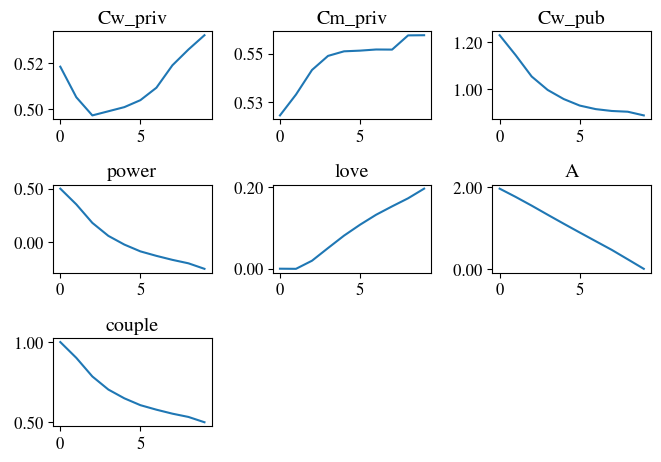

In [ ]:
variables = ['Cw_priv', 'Cm_priv', 'Cw_pub', 'power', 'love', 'A', 'couple',]

for model in models.values():
    fig, axes = make_fig(len(variables), (3,3))
    for ax, var in zip(axes,variables):
        x = np.arange(model.par.T)
        mask = model.sim.couple
        mask = np.ones(model.sim.__dict__[var].shape)
        y = np.nanmean(model.sim.__dict__[var] * mask, axis=0)
        ax.plot(x, y, label=var)
        ax.set_title(var)
    plt.tight_layout()

In [ ]:
(model.sim.__dict__['Cw_priv'] - model.sim.__dict__['Cm_priv']).mean()

-0.03520745729876633